### KMeans Clustering to find the optimal weights for each specific news source

In [1]:
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt

In [4]:
df = pd.read_csv("news_with_risk_score.csv")

df['datetime'] = pd.to_datetime(df['datetime'])
df = df.sort_values('datetime').reset_index(drop=True)
df.head()

,datetime,header,content,source,specific_source,link,risk score
0,2025-03-15 17:55:00,The situation of the market,Many stocks in the market are significantly ov...,Reddit,investing,https://reddit.com/r/investing/comments/1jc0xk...,3
1,2025-03-15 18:26:00,"Week Recap: Is the worst behind us? Mar. 10, 2...","First of all, I don’t want to be misunderstood...",Reddit,StockMarket,https://reddit.com/r/StockMarket/comments/1jc1...,4
2,2025-03-16 12:51:00,"Convince me I shouldn't be a bear now, pt. 2.","Three weeks ago, I made [this](https://www.red...",Reddit,stocks,https://reddit.com/r/stocks/comments/1jckrcz/c...,3
3,2025-03-17 20:06:00,"Mar. 17, 2025 - The S&P 500 closed higher arou...","In the weekend, Scott Bessent said ""I’ve been ...",Reddit,StockMarket,https://reddit.com/r/StockMarket/comments/1jdm...,3
4,2025-03-18 00:20:00,POSITIONS FOR $800->$100k,Since yall can’t stop crying about my position...,Reddit,wallstreetbets,https://reddit.com/r/wallstreetbets/comments/1...,5


List all the unique sources

In [7]:
unique_source = df['specific_source'].unique().tolist()
unique_source

['investing',
 'StockMarket',
 'stocks',
 'wallstreetbets',
 'Etfdailynews',
 'Ndtv',
 'Forbes',
 'Globenewswire',
 'Nbcnews',
 'Investopedia',
 'Bostonherald',
 'Yahoo Finance',
 'Coindesk',
 'Foxbusiness',
 'Telegraph',
 'Fool',
 'Techcrunch',
 'Cnn',
 'Thestreet',
 'Verdict',
 'Denverpost',
 'Marketwatch']

In [9]:
len(unique_source)

22

Round the time to the nearest hour and a half (e.g 8:30, 9:30..)

In [5]:
def round_to_half_hour(dt):
    # If minutes < 30 → set to previous half-hour (hh:30 of previous hour)
    # If minutes >= 30 → set to hh:30 of current hour
    return dt.replace(minute=30, second=0, microsecond=0) if dt.minute >= 30 else (dt - pd.Timedelta(hours=1)).replace(minute=30, second=0, microsecond=0)

In [6]:
df['hour'] = df['datetime'].apply(round_to_half_hour)

In [10]:
pivot = df.pivot_table(index='hour',
                       columns='specific_source',
                       values='risk score',
                       aggfunc='mean',
                       fill_value=0)

In [11]:
pivot = pivot.reset_index()
pivot.head()

specific_source,hour,Bostonherald,Cnn,Coindesk,Denverpost,Etfdailynews,Fool,Forbes,Foxbusiness,Globenewswire,...,Ndtv,StockMarket,Techcrunch,Telegraph,Thestreet,Verdict,Yahoo Finance,investing,stocks,wallstreetbets
0,2025-03-15 17:30:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,4.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0
1,2025-03-16 12:30:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0
2,2025-03-17 19:30:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,2025-03-17 23:30:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0
4,2025-03-18 18:30:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0


Aggregate hourly bin

In [12]:
# Function to aggregate scores per hour
def aggregate_scores(row, weights):
    sources = row.index  
    weighted_sum = sum(weights[i] * row[s] for i, s in enumerate(sources))
    weight_total = sum(weights)
    return weighted_sum / weight_total if weight_total != 0 else 0


# Function to compute clustering quality
def clustering_quality(aggregated_scores, n_clusters=5):
    y = np.array(aggregated_scores).reshape(-1, 1)
    kmeans = KMeans(n_clusters=n_clusters, random_state=0).fit(y)
    labels = kmeans.labels_
    score = silhouette_score(y, labels)
    return score

In [ ]:
source_names = pivot.columns[1:]  
initial_weights = np.ones(len(source_names)) / len(source_names)    # Starting guessed weights 1/22
aggregated_scores = pivot[source_names].apply(lambda row: aggregate_scores(row, initial_weights), axis=1)

### Find optimal n_clusters using elbow method

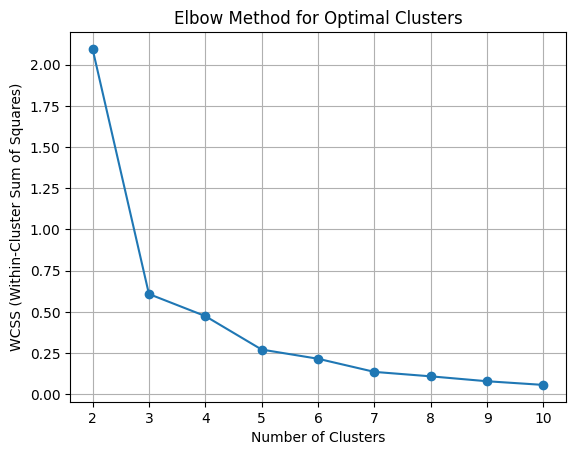

In [14]:
cluster_range = range(2, 11)
wcss = []

# Calculate WCSS for each value of n_clusters
for n_clusters in cluster_range:
    kmeans = KMeans(n_clusters=n_clusters, random_state=0)
    kmeans.fit(aggregated_scores.values.reshape(-1, 1))  # Reshape for single feature (aggregated scores)
    wcss.append(kmeans.inertia_)  # Inertia is the WCSS for that model

# Plot the Elbow Method (WCSS vs. Number of Clusters)
plt.plot(cluster_range, wcss, marker='o')
plt.xlabel('Number of Clusters')
plt.ylabel('WCSS (Within-Cluster Sum of Squares)')
plt.title('Elbow Method for Optimal Clusters')
plt.xticks(cluster_range)
plt.grid(True)
plt.show()

Based on the elbow method, n_clusters=4 is chosen.

### Plot the clusters

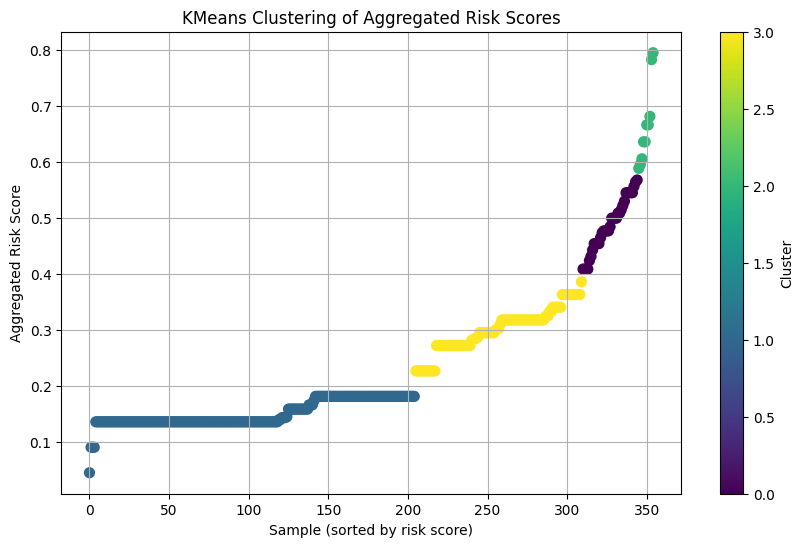

In [15]:
# Prepare for clustering
X = np.array(aggregated_scores).reshape(-1, 1)

# Run KMeans
kmeans = KMeans(n_clusters=4, random_state=0, n_init=10)
labels = kmeans.fit_predict(X)

# Sort by risk score for better visual
sorted_idx = np.argsort(X[:, 0])
X_sorted = X[sorted_idx]
labels_sorted = np.array(labels)[sorted_idx]

plt.figure(figsize=(10, 6))

# Scatter plot: risk score vs cluster
plt.scatter(range(len(X_sorted)), X_sorted[:, 0], c=labels_sorted, cmap='viridis', s=50)

plt.title('KMeans Clustering of Aggregated Risk Scores')
plt.xlabel('Sample (sorted by risk score)')
plt.ylabel('Aggregated Risk Score')
plt.colorbar(label='Cluster')
plt.grid(True)
plt.show()

### Optimize the weights

In [16]:
from scipy.optimize import minimize

# Loss function to minimize (negative silhouette score)
def loss(weights, data):
    weights = np.clip(weights, 1e-6, None)
    agg_scores = data.apply(lambda row: aggregate_scores(row, weights), axis=1)
    return -clustering_quality(agg_scores, n_clusters=4)

# Constraint the sum of weights = 1
constraints = {'type': 'eq', 'fun': lambda w: np.sum(w) - 1}

result = minimize(loss,
                  x0=initial_weights,
                  args=(pivot[source_names],),
                  bounds = [(0.02, 1.0)] * len(source_names),
                  constraints=[constraints])

optimal_weights = result.x
#  Re-normalize after optimization
weights = optimal_weights / np.sum(optimal_weights)


for source, weight in zip(unique_source, weights):
    print(f"{source}: {weight:.4f}")

investing: 0.0360
StockMarket: 0.0647
stocks: 0.0297
wallstreetbets: 0.0609
Etfdailynews: 0.0445
Ndtv: 0.0411
Forbes: 0.0411
Globenewswire: 0.0322
Nbcnews: 0.0402
Investopedia: 0.0492
Bostonherald: 0.0587
Yahoo Finance: 0.0411
Coindesk: 0.0405
Foxbusiness: 0.0411
Telegraph: 0.0645
Fool: 0.0322
Techcrunch: 0.0617
Cnn: 0.0514
Thestreet: 0.0411
Verdict: 0.0480
Denverpost: 0.0386
Marketwatch: 0.0411
